# Least squares method with Flax and Optax

**Note**: This notebook is designed to run on CPU (no GPU) runtime.

**[LSF-01]**

Install libraries.

In [ ]:
%%bash
curl -sLO https://raw.githubusercontent.com/enakai00/colab_jaxbook/main/requirements.txt
pip install -qr requirements.txt
pip list | grep -E '(jax|flax|optax)'

flax                          0.6.1
jax                           0.3.21
jaxlib                        0.3.15+cuda11.cudnn805
optax                         0.1.3


**[LSF-02]**

Import modules.

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
from pandas import DataFrame

import jax, optax
from jax import random, numpy as jnp
from flax import linen as nn
from flax.training import train_state

plt.rcParams.update({'font.size': 12})

**[LSF-03]**

Prepare the ground truth labels.

**Note**: The output from the model is in an array `[y]`, not a scalar `y`. Accordingly, we prepare the labels as a list of an array `[t]`.

In [ ]:
train_t = jnp.asarray([5.2, 5.7, 8.6, 14.9, 18.2, 20.4,
                       25.5, 26.4, 22.8, 17.5, 11.1, 6.6])
train_t = train_t.reshape([12, 1])
train_t

DeviceArray([[ 5.2],
             [ 5.7],
             [ 8.6],
             [14.9],
             [18.2],
             [20.4],
             [25.5],
             [26.4],
             [22.8],
             [17.5],
             [11.1],
             [ 6.6]], dtype=float32)

**[LSF-04]**

Prepare the input data.

`train_x` contains the input values $(x^1, x^2, x^3, x^4)\ (x=1,\cdots,12)$ to the model in the design matrix form:

$$
\mathbf X = \begin{pmatrix}
1^1 & 1^2 & 1^3 & 1^4 \\
2^1 & 2^2 & 2^3 & 2^4 \\
\vdots & \vdots & \vdots & \vdots \\
12^1 & 12^2 & 12^3 & 12^4
\end{pmatrix}
$$

In [ ]:
train_x = jnp.asarray([[month**n for n in range(1, 5)]
                       for month in range(1, 13)])
train_x

DeviceArray([[    1,     1,     1,     1],
             [    2,     4,     8,    16],
             [    3,     9,    27,    81],
             [    4,    16,    64,   256],
             [    5,    25,   125,   625],
             [    6,    36,   216,  1296],
             [    7,    49,   343,  2401],
             [    8,    64,   512,  4096],
             [    9,    81,   729,  6561],
             [   10,   100,  1000, 10000],
             [   11,   121,  1331, 14641],
             [   12,   144,  1728, 20736]], dtype=int32)

**[LSF-05]**

Define a model to predict the label values against a batch `x`.

**Note**: The input to the model is in a batch form like `train_x`. The output from the model is in a batch from like `train_t` accordingly.

In [ ]:
class TemperatureModel(nn.Module):
    @nn.compact
    def __call__(self, x):
        y = nn.Dense(features=1)(x)
        return y

**[LSF-06]**

Generate inital parameter values. The parameter values are stored in `variable['params']`

**Note**: To get the initial values of model parameters with `TemperatureModel().init()`, you should supply the random number generator (random seed) and a sample batch input to the model.

In [ ]:
key, key1 = random.split(random.PRNGKey(0))
variables = TemperatureModel().init(key1, train_x)
variables

FrozenDict({
    params: {
        Dense_0: {
            kernel: DeviceArray([[-0.70585155],
                         [-0.29513752],
                         [ 0.52288806],
                         [-0.06666087]], dtype=float32),
            bias: DeviceArray([0.], dtype=float32),
        },
    },
})

**[LSF-07]**

Create a training state object that contains:

- Model function to get predictions: `apply_fn`
- Model parameters: `params`
- Optimizer information: `tx`

We use the Adam optimizer here.


In [ ]:
state = train_state.TrainState.create(
    apply_fn=TemperatureModel().apply,
    params=variables['params'],
    tx=optax.adam(learning_rate=0.001))

**[LSF-08]**

Define a loss function as the mean square error. The first parameter of `loss_fn` should be the model parameters.

In [ ]:
@jax.jit
def loss_fn(params, state, inputs, labels):
    predicts = state.apply_fn({'params': params}, inputs)
    loss = optax.l2_loss(predicts, labels).mean()
    return loss

**[LSF-09]**

Define a function to apply a single training step that returns a new training state.

In [ ]:
@jax.jit
def train_step(state, inputs, labels):
    loss, grads = jax.value_and_grad(loss_fn)(
        state.params, state, inputs, labels)
    new_state = state.apply_gradients(grads=grads)
    return new_state, loss

**[LSF-10]**

Repeat applying the training step.

**Note**: You can use `jax.device_get()` to explicitly copy values from GPU memory to the system memory.

In [ ]:
%%time
loss_history = []
for step in range(1, 100001):
    state, loss_val = train_step(state, train_x, train_t)
    loss_history.append(jax.device_get(loss_val).tolist())
    if step % 10000 == 0:
        print ('Step: {}, Loss: {:0.4f}'.format(step, loss_val),
               flush=True)        

Step: 10000, Loss: 2.3245
Step: 20000, Loss: 1.4010
Step: 30000, Loss: 1.3200
Step: 40000, Loss: 1.3073
Step: 50000, Loss: 1.2041
Step: 60000, Loss: 1.1638
Step: 70000, Loss: 1.1051
Step: 80000, Loss: 1.0609
Step: 90000, Loss: 1.0201
Step: 100000, Loss: 0.9823
CPU times: user 6.65 s, sys: 46.8 ms, total: 6.7 s
Wall time: 7.16 s


**[LSF-11]**

Show charts of the loss history.

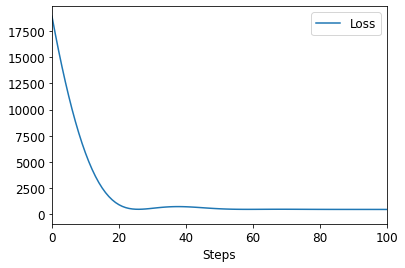

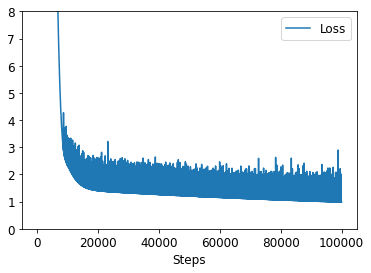

In [ ]:
df = DataFrame({'Loss': loss_history})
df.index.name = 'Steps'
_ = df.plot(figsize=(6, 4), xlim=(0, 100))

df = DataFrame({'Loss': loss_history})
df.index.name = 'Steps'
_ = df.plot(figsize=(6, 4), ylim=(0, 8))

**[LSF-12]**

Show weights after the training.

In [ ]:
state.params

FrozenDict({
    Dense_0: {
        bias: DeviceArray([2.9621983], dtype=float32),
        kernel: DeviceArray([[-0.7491121 ],
                     [ 1.5364609 ],
                     [-0.17362942],
                     [ 0.00433857]], dtype=float32),
    },
})

**[LSF-13]**

Plot a chart for predictions.

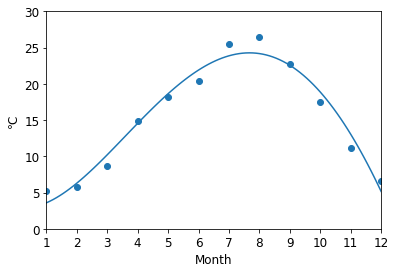

In [ ]:
xs = np.linspace(1, 12, 100)
inputs = jnp.asarray([[month**n for n in range(1, 5)]
                      for month in xs])
ys = state.apply_fn({'params': state.params}, inputs)

fig = plt.figure(figsize=(6, 4))
subplot = fig.add_subplot(1, 1, 1)
subplot.set_xlim(1, 12)
subplot.set_ylim(0, 30)
subplot.set_xticks(range(1, 13))
subplot.set_xlabel('Month')
subplot.set_ylabel('℃')

subplot.scatter(range(1, 13), train_t)
_ = subplot.plot(xs, ys)